In [1]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Parameters
learning_rate = 0.01
batch_size = 100
val_perc = 0.2 # Validations set size 
iters = 20 # Epochs

In [3]:
# Download Dataset
dataset = MNIST(root='data/', download=True)

In [4]:
train_dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())

In [5]:
# Create Validation set

def split_indices(n, val_perc, seed=99):
    
    # Determine size of validation set
    n_val = int(val_perc * n)

    # Set random seed
    np.random.seed(seed)
    
    # Create random permutation of 0 to n-1
    indices = np.random.permutation(n)

    # Pick first n_val indices for validation set
    return indices[n_val:], indices[:n_val]

train_indices, val_indices = split_indices(len(dataset), val_perc, seed=42)

In [6]:
# Training sampler and Data Loader
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(train_dataset, batch_size, sampler=train_sampler)

# Validation sampler and Data Loader
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(train_dataset, batch_size, sampler=val_indices)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [9]:
class DeviceDataLoader():
    '''Wrap a dataloader to move data to device'''
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        '''Yield a batch of data after moving it to device'''
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        '''Number of batches'''
        return len(self.dl)

In [10]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [11]:
# Create Model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        self.pool1 = nn.MaxPool2d(2, 2)              
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) 
        self.pool2 = nn.MaxPool2d(2, 2)              
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
# Metric
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [13]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_func(preds, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)

    return loss.item(), len(xb), metric_result

In [14]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        losses, nums, metrics = zip(*results)
        total_size = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses,nums)) / total_size
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total_size

        return avg_loss, total_size, avg_metric

In [15]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl, metric=None):
    accuracies = []
    for epoch in range(epochs):
        for xb, yb in train_dl:
            loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)

        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'.format(epoch+1, epochs, val_loss, metric.__name__, val_metric))
            accuracies.append(val_metric)

    return accuracies

In [16]:
model = CNN()
to_device(model, device)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
accuracies = fit(iters, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

Epoch [1/20], Loss: 0.6046, accuracy: 0.8120
Epoch [2/20], Loss: 0.3533, accuracy: 0.8877
Epoch [3/20], Loss: 0.2449, accuracy: 0.9278
Epoch [4/20], Loss: 0.2037, accuracy: 0.9387
Epoch [5/20], Loss: 0.1764, accuracy: 0.9458
Epoch [6/20], Loss: 0.1547, accuracy: 0.9522
Epoch [7/20], Loss: 0.1325, accuracy: 0.9613
Epoch [8/20], Loss: 0.1156, accuracy: 0.9668
Epoch [9/20], Loss: 0.1094, accuracy: 0.9689
Epoch [10/20], Loss: 0.1009, accuracy: 0.9723
Epoch [11/20], Loss: 0.0918, accuracy: 0.9736
Epoch [12/20], Loss: 0.0890, accuracy: 0.9742
Epoch [13/20], Loss: 0.0802, accuracy: 0.9771
Epoch [14/20], Loss: 0.0756, accuracy: 0.9780
Epoch [15/20], Loss: 0.0741, accuracy: 0.9785
Epoch [16/20], Loss: 0.0756, accuracy: 0.9786
Epoch [17/20], Loss: 0.0686, accuracy: 0.9802
Epoch [18/20], Loss: 0.0682, accuracy: 0.9807
Epoch [19/20], Loss: 0.0676, accuracy: 0.9804
Epoch [20/20], Loss: 0.0661, accuracy: 0.9808


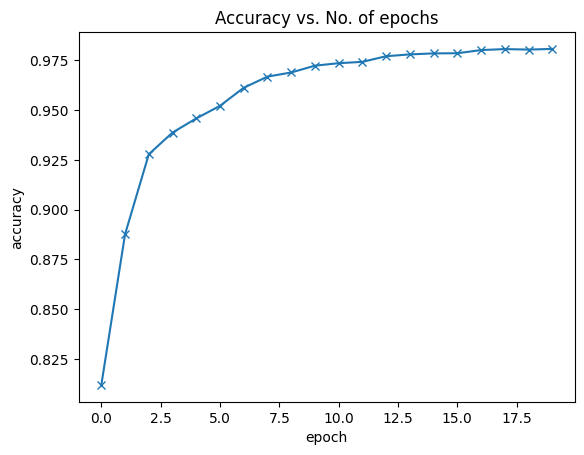

In [17]:
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [18]:
test_loader = DataLoader(test_dataset, batch_size=200)
test_loader = DeviceDataLoader(test_loader, device)

test_loss, total, test_acc = evaluate(model, F.cross_entropy, test_loader, metric=accuracy)
print('Loss: {:4f}, Accuracy: {:.4f}'.format(test_loss, test_acc))

Loss: 0.058834, Accuracy: 0.9802
